In [16]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 240
ANOMALY_RATE = 0.1
# CapMix parameters
CUT_RATE = 0.2
TREND_RATE = 0.5  # 0.5 standard deviation per step
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)


# CAP function

In [17]:

def cut_add_paste_window(window_data, cut_source_data):
    aug_window = window_data.copy()
    seq_len, n_features = aug_window.shape
    radius = int(seq_len * CUT_RATE)
    if radius < 1: radius = 1
    
    # select position
    if seq_len - radius <= 0: return aug_window
    from_pos = np.random.randint(0, seq_len - radius)
    to_pos = np.random.randint(0, seq_len - radius)
    
    # Cut
    patch = cut_source_data[from_pos : from_pos + radius, :].copy()
    
    # Add (Trend)
    if n_features > 1:
        dim_size = np.random.randint(1, n_features + 1)
        selected_dims = np.random.choice(np.arange(n_features), size=dim_size, replace=False)
    else:
        selected_dims = [0]

    factor = np.random.rand() * TREND_RATE
    slope = np.random.choice([-1, 1]) * factor * np.arange(radius)
    
    for item in selected_dims:
        patch[:, item] += slope

    # Paste
    aug_window[to_pos : to_pos + radius, :] = patch
    return aug_window



# Load data

In [18]:

df = pd.read_csv('system-2.csv')
with open('metrics.json', 'r') as f:
    METRIC_NAMES = json.load(f)
data = df[METRIC_NAMES].values

split_idx = int(len(data) * 0.7)
test_data_raw = data[split_idx:]
train_data_raw = data[:split_idx]

# normalize for cap 
scaler = StandardScaler()
scaler.fit(train_data_raw)
test_data_scaled = scaler.transform(test_data_raw)


# Synthetic anomaly injection

In [19]:

# generate anomalies in normalized data
X_test_synthetic_scaled = []
y_test = []

step = SEQ_LEN // 2
for i in range(0, len(test_data_scaled) - SEQ_LEN, step):
    window = test_data_scaled[i : i + SEQ_LEN]
    
    if np.random.rand() < ANOMALY_RATE:
        # random window
        rand_idx = np.random.randint(0, len(test_data_scaled) - SEQ_LEN)
        source_window = test_data_scaled[rand_idx : rand_idx + SEQ_LEN]
        
        # generate anomaly
        anom_window = cut_add_paste_window(window, source_window)
        
        X_test_synthetic_scaled.append(anom_window)
        y_test.append(1)
    else:
        X_test_synthetic_scaled.append(window)
        y_test.append(0)

X_test_synthetic_scaled = np.array(X_test_synthetic_scaled)
y_test = np.array(y_test)


# Save synthetic test data

In [20]:

# Inverse Transform 
print("Inverting the transformation to original units")
X_test_synthetic_raw = np.zeros_like(X_test_synthetic_scaled)

for i in range(len(X_test_synthetic_scaled)):
    X_test_synthetic_raw[i] = scaler.inverse_transform(X_test_synthetic_scaled[i])


Inverting the transformation to original units


In [21]:

np.save('X_test_synthetic_raw.npy', X_test_synthetic_raw)
np.save('y_test_synthetic.npy', y_test)


# Visualization of Anomalies

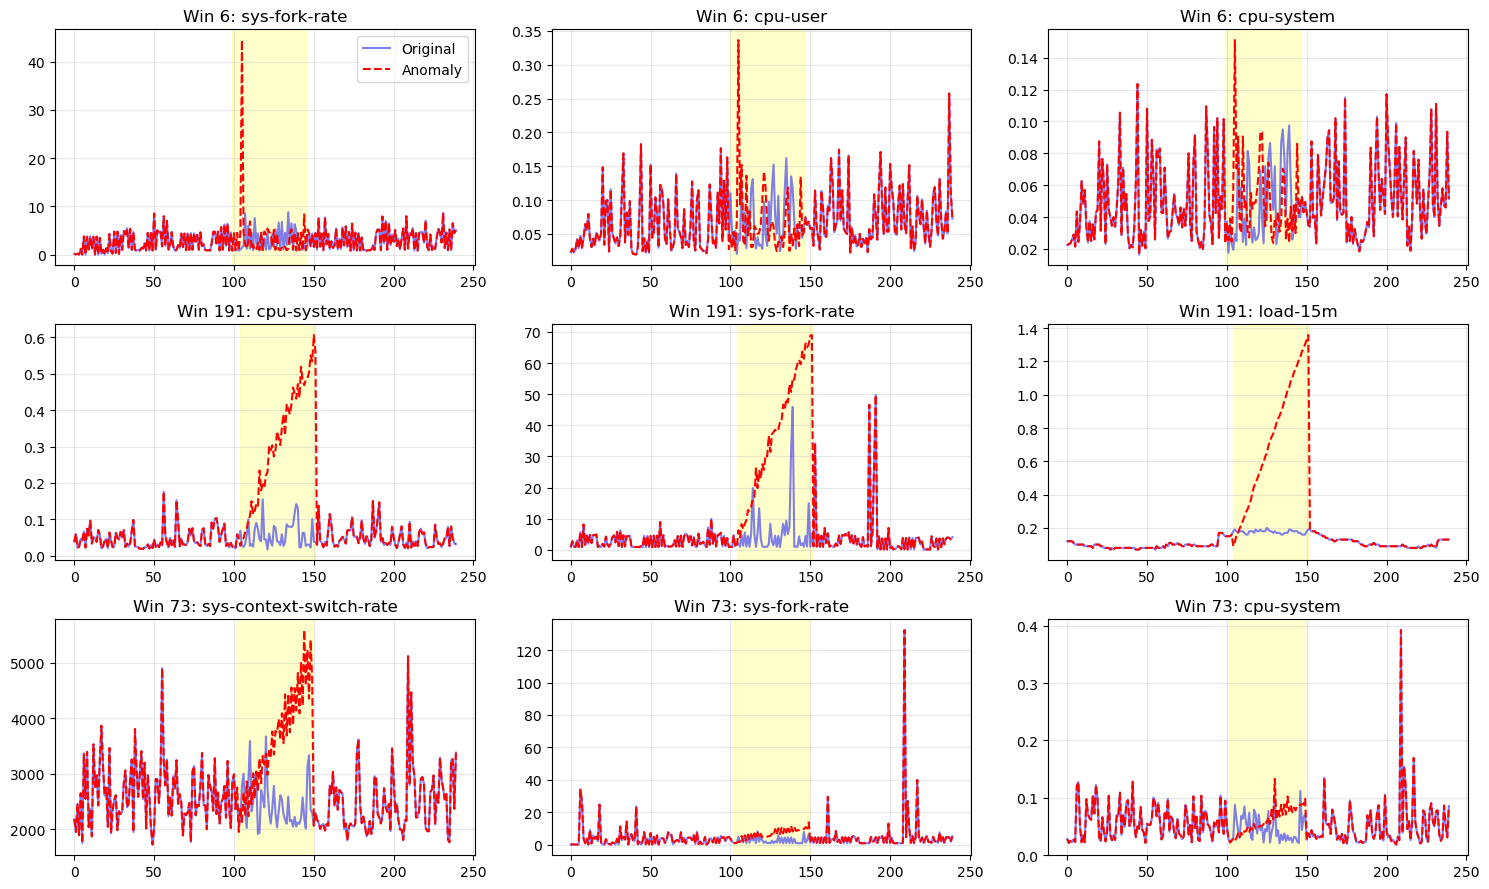

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize(raw_data, synthetic_windows, labels, metric_names, n_samples=3, n_metrics=3):
    anom_idxs = np.where(labels == 1)[0]
    
    # get random indexes 
    idxs = np.random.choice(anom_idxs, min(n_samples, len(anom_idxs)), replace=False)
    
    fig, axes = plt.subplots(len(idxs), n_metrics, figsize=(15, 3 * len(idxs)), squeeze=False)
    
    seq_len = synthetic_windows.shape[1]
    step = seq_len // 2 
    std_devs = raw_data.std(axis=0) + 1e-9 
    
    for row, idx in enumerate(idxs):
        dirty = synthetic_windows[idx]
        clean = raw_data[idx*step : idx*step + seq_len] 
        
        scores = np.max(np.abs(clean - dirty) / std_devs, axis=0)
        top_cols = np.argsort(scores)[::-1][:n_metrics]
        
        for col, metric_idx in enumerate(top_cols):
            ax = axes[row, col]
            
            ax.plot(clean[:, metric_idx], color='blue', alpha=0.5, label='Original')
            ax.plot(dirty[:, metric_idx], color='red', linestyle='--', label='Anomaly')
            
            diff_locs = np.where(np.abs(clean[:, metric_idx] - dirty[:, metric_idx]) > 1e-6)[0]
            if len(diff_locs) > 0:
                ax.axvspan(diff_locs[0], diff_locs[-1], color='yellow', alpha=0.2)
            
            ax.set_title(f"Win {idx}: {metric_names[metric_idx]}")
            ax.grid(True, alpha=0.3)
            
    axes[0, 0].legend(loc='upper right') 
    plt.tight_layout()
    plt.show()

# Виклик:
simple_visualize(test_data_raw, X_test_synthetic_raw, y_test, METRIC_NAMES)